**Table of contents**<a id='toc0_'></a>    
- [Introduction](#toc1_)    
  - [Causal Theory a Primer](#toc1_1_)    
- [Methodology and Results](#toc2_)    
  - [Data Generation](#toc2_1_)    
  - [First (naive) strategy: assuming "No hidden confounders"](#toc2_2_)    
  - [Second strategy: keeping into account the latent variable](#toc2_3_)    
    - [Simple Latent Variable Model](#toc2_3_1_)    
      - [Generative Model Specification](#toc2_3_1_1_)    
      - [Variational Inference with SVI](#toc2_3_1_2_)    
      - [Test-Time Inference Model](#toc2_3_1_3_)    
      - [Estimating ATE and ITE](#toc2_3_1_4_)    
        - [A note about the test time inference](#toc2_3_1_4_1_)    
    - [Causal Effect Variational AutoEncoders (CEAVE)](#toc2_3_2_)    
      - [Inference Network (Encoder)](#toc2_3_2_1_)    
      - [Model Network (Decoder)](#toc2_3_2_2_)    
      - [Training Phase](#toc2_3_2_3_)    
      - [Prediction Phase](#toc2_3_2_4_)    
    - [ITE results Linear Dataset](#toc2_3_3_)    
    - [ITE results Non Linear Dataset](#toc2_3_4_)    
      - [Internal Representation](#toc2_3_4_1_)    
- [Experiments](#toc3_)    
    - [Setting parameters defaults](#toc3_1_1_)    
    - [E1: increasing sample size](#toc3_1_2_)    
    - [E2: increasing correlation among proxies (not through $Z$)](#toc3_1_3_)    
    - [E3: increasing decorellation among proxies (through shuffling)](#toc3_1_4_)    
    - [E4: increasing the latent dimension (of the CEVAE)](#toc3_1_5_)    
    - [E5: prior misspecification](#toc3_1_6_)    
    - [E8: increasing the number of proxies](#toc3_1_7_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## 

# <a id='toc1_'></a>[Introduction](#toc0_)



We are in the context of an **observational study**: we observe outcomes ($Y$) for available subjects (with many characteristics $X_i$) on the variables of interest ($T$) without control over this variable. This setting poses a problem: there may be lurking variables not taken into account who affect both the treatment and the outcome (i.e., confounders) making the establishment of cause and effect much harder.

This stands in contrast to Randomized Clinical Trials (RCTs), where instead we can randomize the assignment of the subjects to the values of the variable of interest so that no confounders are present.

**Causal Graphical Model (Causal Bayesian Network)**

![image.png](attachment:image.png)

We **observe** the features $X_i$, the treatment $T$ and the outcome $Y$, but we do **not observe** the hidden confounder $Z$!

Our **objective** is to estimate the **Average Treatment Effect** (ATE), i.e., the effect of $T$ on $Y$.

## <a id='toc1_1_'></a>[Causal Theory a Primer](#toc0_)

The term association refers to statistical dependence. Causality is a special kind of association, so causality implies association but not viceversa. 

Let $T$ be the random variable for the treatment, $Y$ the r.v. for the oucome of nterest and X to denote covariates. Assume for example a binary treatment, *i.e.*, $t\in{0,1}$ where $t$ is the realization of $T$.
The **potential outcome** $Y(t)$ denotes what the outcome would be after the treatment $T=t$, i.e., all the possible outcomes after each possible treatment.

In general we consider many individuals in the population of size $n$. We define the **Individual Treatment Effect** (ITE) as:

$$
\tau_i=Y_i(1)-Y_i(0)
$$

The *fundamental problem of causal inference* is that we cannot observe both $Y_i(0)$ and $Y_i(1)$ for the same individual and so neither the ITE. The idea is to use the **Average Treatment Effect** (ATE):

$$
\text{ATE} = \mathbb{E}[Y(1)-Y(0)]
$$

# <a id='toc2_'></a>[Methodology and Results](#toc0_)

## <a id='toc2_1_'></a>[Data Generation](#toc0_)
We generated synthetic data in the following way:

- the hidden confounder is one dimensional with distribution
$$
Z \sim \mathcal{N}(0,1)
$$
- the proxies from which we study the confounder
$$
X_j \sim \mathcal{N}(a_j z,\sigma_X^2)\,,\quad a_j \sim \mathcal{U}_{[-10,10]}
$$
- the treatment and the outcome are
$$
T|Z=z \sim \text{Bernoulli}(\sigma(\beta z))
$$
$$
Y|Z=z,T=t \sim \mathcal{N}(z + t, \sigma_Y^2)

In [1]:
from dowhy import CausalModel
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import pyro
from pyro.contrib.cevae import CEVAE
import torch
import matplotlib.pyplot as plt
import logging
from utils import *
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns


logging.getLogger("pyro").setLevel(logging.DEBUG)
logging.getLogger("pyro").handlers[0].setLevel(logging.DEBUG)

In [2]:
data = synthetic_dataset_linear(n=1000, beta=2.0, num_proxies=10, seed=0)

length_x = len(data["x"][1]) 

#clone
data_original = data.copy()

# translating the dictionary in a dataframe
# I need to change the x matrix in different x columns
for i in range(data["x"].shape[1]):
    data["x_"+str(i)] = data["x"][:,i]

data.pop("x",None)
data.pop("a",None)
data_df = pd.DataFrame.from_dict(data)
data_df.head()

,t,y,z,ite,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9
0,0.0,-1.868301,-1.125840,1.0,-10.419271,-0.488647,7.174606,-4.648432,-4.576821,7.489878,6.996157,-4.095944,0.897944,9.790544
1,0.0,-0.538289,-1.152360,1.0,-9.362418,2.158251,7.738794,-4.534320,-5.552610,6.954226,5.887638,-5.219081,1.483338,11.746528
2,0.0,-3.903064,-0.250579,1.0,-0.370637,-1.324946,1.612699,-1.358586,-0.889863,2.247172,-0.042243,-2.090028,0.893964,2.806923
3,1.0,1.080067,-0.433879,1.0,-3.855381,-1.410040,0.407185,-0.369522,-2.708030,4.276382,1.373499,-4.581057,0.293072,4.355963
4,0.0,1.667862,0.848710,1.0,8.152637,-0.456173,-5.582678,0.746877,3.758286,-4.447976,-5.754533,4.323848,-1.834779,-8.086730


More information and plots about the syntetic generated data can be found in [this notebook](./synthetic_dataset.ipynb).

We can obtain a naive estimate for the ATE by taking the mean of the outcome in the two groups in the dataset (those that received the treatment and those who didn't). We call this estimate "unadgusted" because we are not considering any of the covariates that can affect the treatment effect.

In [3]:
data_1 = data_df[data_df["t"]==1.0]
data_0 = data_df[data_df["t"]==0.0]

print("Unadjusted ATE", np.mean(data_1["y"])- np.mean(data_0["y"]))

Unadjusted ATE 2.1330922


## <a id='toc2_2_'></a>[First (naive) strategy: assuming "No hidden confounders"](#toc0_)

Assuming that there are no hidden confounders (also called **unconfoundness**) means that we consider the $X_i$ to be the only confounders and thus we consider them to be measured!

There exists a simple graphical test, the *back-door criterion*, that can be applied to the causal diagram in order to test if a subset of variables is sufficient to yield an unbiased estimate of the causal effect P(y|do(T=t)).

**Back-door criterion**:
A set of variables X satisfies the criterion relative to an ordered pair of variables $(T,Y)$ in a directed acyclic graph G if:
- no node in X is a descendant of $T$
- X blocks every path from $T$ to $Y$

In this case the set of variables $X_i$ satisfy the back-door criterion and we can apply classical methods for causal inference.

In [4]:
# model = CausalModel(data_df, treatment="t", outcome="y", common_causes="z")
# this would be the real model since we know how the data was generated
# however, in a real setting, we don't usually have access to the real confounders and we consider the proxies variables we have for it instead  

model = CausalModel(data_df, treatment="t", outcome="y", common_causes=["x_"+str(i) for  i in range(0,10)])

![](../images/causal_model_no_hidden_confounder.png)

We identify the **estimand** using the back-door criterion. Again, we remark the need for the unconfoundedness assumption.

The estimand type is **non parametric** because we are **not** assuming any parametric model for the treatment effect.

The other two types of estimand (instrumental variable and front-door criterion) are **not** available because there are no instrumental variables or mediators in the causal graph. 


In [5]:
#Identify the causal effect
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d                                                
────(E[y|x_0,x_4,x_3,x_8,x_9,x_2,x_6,x_7,x_5,x_1])
d[t]                                              
Estimand assumption 1, Unconfoundedness: If U→{t} and U→y then P(y|t,x_0,x_4,x_3,x_8,x_9,x_2,x_6,x_7,x_5,x_1,U) = P(y|t,x_0,x_4,x_3,x_8,x_9,x_2,x_6,x_7,x_5,x_1)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



We want to compute how the value of $y$ will change with respect to $T$, controlling for all $X_i$.

Since we have obtained a backdoor set we use the *Back-door adjustment*:
If a set of variables X satisfy the back-door criterion relative to (T,Y) then the causal effect of T on Y is identifiable and is given by the formula:
$$p(y|do(t))=\sum_x P(y|t,x)P(x)$$

We can see from this formula that estimating the back-door adjust is thus equivalent to estimate the conditional probability distribution $P(y|t,x)$. One of the most common method to do so is to use *linear regression*. 

The linear regression method is useful when the data-generating process for the outcome Y can be approximated as the linear function $Y = \beta_0 + \beta_1 T + \beta_2 X + \varepsilon$. When we fit the linear model we are estimating $\mathbb{E}[Y|T=t,X=x]$.

We exploit this expected value to compute the ITE. We obtain:
$$ ITE(x) = \mathbb{ E}[Y|T=1,X=x] - \mathbb{E}[Y|T=0,X=x] = \beta_1$$
To obtain the ATE we would then take the mean:
$$ ATE = \frac1N \sum_{i=1}^N \mathbb{ E}[Y|T=1,X=x_i] - \mathbb{E}[Y|T=0,X=x_i]$$
but this is not really necessary since the ITE is the same for all points.

In [6]:
# Estimate the causal effect and compare it with Average Treatment Effect
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression", test_significance=True
)

print(estimate)


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d                                                
────(E[y|x_0,x_4,x_3,x_8,x_9,x_2,x_6,x_7,x_5,x_1])
d[t]                                              
Estimand assumption 1, Unconfoundedness: If U→{t} and U→y then P(y|t,x_0,x_4,x_3,x_8,x_9,x_2,x_6,x_7,x_5,x_1,U) = P(y|t,x_0,x_4,x_3,x_8,x_9,x_2,x_6,x_7,x_5,x_1)

## Realized estimand
b: y~t+x_0+x_4+x_3+x_8+x_9+x_2+x_6+x_7+x_5+x_1
Target units: ate

## Estimate
Mean value: 0.8985665542871683
p-value: [4.33652909e-26]



We can also explicitely compute the linear regression using scikit-learn: we verify that the result is the same!

In [5]:
x_linear, t_linear, y_linear, z_linear, ite_cevae_linear = (
    data_original["x"],
    data_original["t"],
    data_original["y"],
    data_original["z"],
    data_original["ite"]
)

x_train_linear, x_test_linear, t_train_linear, t_test_linear, y_train_linear, y_test_linear, z_train_linear, z_test_linear, ite_train_linear, ite_test_linear = train_test_split(
    x_linear, t_linear, y_linear, z_linear, ite_cevae_linear, test_size=0.2, random_state=0
)

In [6]:
linear_model_ld = LinearModel()

linear_model_ld.fit(x_train_linear, t_train_linear, y_train_linear)          
ite_linear_model_ld = linear_model_ld.ite(x_test_linear)         
ate_linear_model_ld = ite_linear_model_ld.mean().item()

print("Average Treatment Effect (ATE):", ate_linear_model_ld)

Average Treatment Effect (ATE): 0.8841645121574402


We estimated that receiving the treatment (t=1) increases the outcome of $1.291$ units after adjusting for covariates. This estimates has a very small p-value, suggesting that this effect is statistically significant.

**Remark**: We also verified that, if I give to the model the real hidden confounder (Z), it correctly predicts a causal effect close to 1 for all estimation methods!

## <a id='toc2_3_'></a>[Second strategy: keeping into account the latent variable](#toc0_)

### <a id='toc2_3_1_'></a>[Simple Latent Variable Model](#toc0_)
This is a simple one-dimensional latent variable model implemented in Pyro for estimating the Average Treatment Effect (ATE) and Individual Treatment Effects (ITE).

#### <a id='toc2_3_1_1_'></a>[Generative Model Specification](#toc0_)

For each data point $i=1,\dots,N$:

1. **Prior on the latent**

   $$
   z_i \sim \mathcal{N}(0,\,1).
   $$

2. **Covariate generation**

   $$
   x_i \mid z_i \sim \mathcal{N}(a\,z_i + b,\; \text{diag}(\sigma_x^2)),
   $$

   where:

   * $a, b \in \mathbb{R}^D$
   * $\sigma_x \in \mathbb{R}^D_{>0}$ is a vector of standard deviations.

3. **Treatment assignment**

   $$
   t_i \mid z_i \sim \mathrm{Bernoulli}(\sigma(c\,z_i)),
   $$

   with scalar $c$ controlling how $z$ influences the treatment probability.

4. **Outcome generation**

   $$
   y_i \mid t_i, z_i \sim \mathcal{N}(e\,t_i + f\,z_i,\,\sigma_y^2),
   $$

   where:

   * $e$ is the Average Treatment Effect (ATE) parameter.
   * $f$ is the coefficient for $z$ in the outcome model.
   * $\sigma_y>0$ is the outcome noise standard deviation.

#### <a id='toc2_3_1_2_'></a>[Variational Inference with SVI](#toc0_)

To learn both the generative parameters and approximate the posterior of $z$, we use Stochastic Variational Inference (SVI):

1. **Evidence Lower Bound (ELBO)**

   $$
   \mathcal{L}(\theta, \phi)
   = \mathbb{E}_{q_\phi(z)}[\log p_\theta(x,t,y,z)]
   \;-\;
   \mathrm{KL}\bigl(q_\phi(z)\,\|\,p(z)\bigr).
   $$

   * $\theta$: generative parameters.
   * $\phi$: variational parameters (means and scales of each $z_i$).

2. **Autoguide**
   Pyro’s `AutoDiagonalNormal` constructs a mean-field variational family:

   $$
   q_\phi(z) = \prod_{i=1}^N \mathcal{N}(z_i\mid\mu_i,\sigma_i^2).
   $$

3. **Optimization**

   * Use Adam optimizer over $\theta$ and $\phi$.
   * Each `svi.step(x,t,y)`:

     * Samples $z\sim q_\phi(z)$.
     * Estimates the ELBO via Monte Carlo.
     * Updates both generative and variational parameters via gradients.

4. **Freezing generative parameters**
   After training on (x, t, y), generative parameters are saved and frozen to maintain a fixed model for downstream inference.

#### <a id='toc2_3_1_3_'></a>[Test-Time Inference Model](#toc0_)

To compute potential outcomes and ITEs on new data without observing $y$:

* **`model_xt`**: the same generative process but with no observed $y$.
* **`guide_xt`**: a new `AutoDiagonalNormal` trained by SVI on (x, t) while keeping $\theta$ fixed.


#### <a id='toc2_3_1_4_'></a>[Estimating ATE and ITE](#toc0_)

* **ATE**: The parameter `e` directly represents the average treatment effect:

  $$
  \mathrm{ATE} = e.
  $$

* **ITE**:

  * **On training data** (`ite_train`):

    $$
    \mathrm{ITE}_i
    = 
    \bigl(e + f\,\mathbb{E}[z_i\mid x_i, t_i=1]\bigr)
    -
    \bigl(f\,\mathbb{E}[z_i\mid x_i, t_i=0]\bigr).
    $$
  * **On new data** (`ite`), *i.e.*, at test time:

    1. Instantiate a local guide on $(x_{\text{new}}, t=0)$ and $(x_{\text{new}}, t=1)$.
    2. Perform a few local SVI steps to fit variational means and scales for $N_{\text{new}}$ latents.
    3. Extract mean estimates $\mu^{(0)}, \mu^{(1)}$ and compute

       $$
       \mathrm{ITE}_i
       = \bigl(e + f\,\mu_i^{(1)}\bigr)
       - \bigl(f\,\mu_i^{(0)}\bigr).
       $$

In [7]:
pgm_linear = PyroLinearProxyModel(init_scale=0.1, learning_rate=5e-3, weight_decay=0.0)

losses_pgm_linear = pgm_linear.fit(x_train_linear, t_train_linear, y_train_linear, num_epochs=1000, log_every=100, posterior_epochs=1000)          

ite_pgm_linear = pgm_linear.ite(x_test_linear)         
ate_pgm_linear = ite_pgm_linear.mean().item()

mse_pgm_linear = torch.mean((ite_pgm_linear.flatten() - ite_test_linear.flatten()) ** 2).item()

print("Results for training data")
print("Average Treatment Effect (ATE) (through ITE)", ate_pgm_linear)
print("Estimated ATE fro model coefficients (by def):", pgm_linear.estimate_ate())
print("Mean Squared Error between true ITE and computed ITE:", mse_pgm_linear)

[SVI] epoch  100 ELBO = 79968.01
[SVI] epoch  200 ELBO = 50674.80
[SVI] epoch  300 ELBO = 35281.04
[SVI] epoch  400 ELBO = 27172.07
[SVI] epoch  500 ELBO = 22862.58
[SVI] epoch  600 ELBO = 20575.33
[SVI] epoch  700 ELBO = 19195.69
[SVI] epoch  800 ELBO = 18320.64
[SVI] epoch  900 ELBO = 17897.91
[SVI] epoch 1000 ELBO = 17515.75
[SVI-xt] epoch  101 ELBO = 43949.81
[SVI-xt] epoch  201 ELBO = 35418.95
[SVI-xt] epoch  301 ELBO = 29258.11
[SVI-xt] epoch  401 ELBO = 25355.31
[SVI-xt] epoch  501 ELBO = 22700.72
[SVI-xt] epoch  601 ELBO = 20803.84
[SVI-xt] epoch  701 ELBO = 19370.60
[SVI-xt] epoch  801 ELBO = 18560.36
[SVI-xt] epoch  901 ELBO = 17776.57
Results for training data
Average Treatment Effect (ATE) (through ITE) 0.9676624536514282
Estimated ATE fro model coefficients (by def): 0.9868317246437073
Mean Squared Error between true ITE and computed ITE: 0.04297225922346115


##### <a id='toc2_3_1_4_1_'></a>[A note about the test time inference](#toc0_)
For each $z_i$ there is a pair $(\mu_i,\sigma_i)$, so if we want to predict $z$ for unseen values of $x$ we must train again the model on the new data points.

In [8]:
loc   = pyro.param("AutoDiagonalNormal.loc")   # shape [N]
scale = pyro.param("AutoDiagonalNormal.scale") # shape [N]

# Example: pick out the first few
for i in range(10):
    print(f"z_{i} ~ Normal(mean={loc[i].item():.2f}, std={scale[i].item():.2f})")

z_0 ~ Normal(mean=0.26, std=0.11)
z_1 ~ Normal(mean=0.71, std=0.12)
z_2 ~ Normal(mean=0.12, std=0.11)
z_3 ~ Normal(mean=0.26, std=0.10)
z_4 ~ Normal(mean=0.47, std=0.11)
z_5 ~ Normal(mean=-0.17, std=0.12)
z_6 ~ Normal(mean=0.23, std=0.12)
z_7 ~ Normal(mean=-0.15, std=0.10)
z_8 ~ Normal(mean=-0.33, std=0.10)
z_9 ~ Normal(mean=-0.31, std=0.10)


If we want to predict the ITE for unseen data, *i.e.*, on the test set, we need to train the inference model $q(z_i|x_i,t_i)$ and then "pass" the obtained mean value $\mu_i$ to the generative model (its enough just to use the stored parameter if we just want to compute the mean values of the other variables). This is doable in principle only for small test samples, otherwise we need to use a more complex model like the CEVAE.

In [9]:
ite_pred_linear = pgm_linear.ite(x_test_linear)
mse = torch.mean((ite_pred_linear.flatten() - ite_test_linear.flatten()) ** 2).item()

print("Predicted ITEs:", ite_pred_linear)
print("Mean Squared Error between predicted ITE and true ITE:", mse)
ate_pred_linear = pgm_linear.estimate_ate()
print("Predicted ATE (through ITE)", ite_pred_linear.mean(0).item())
print("Predicted ATE (with params):", ate_pred_linear)


Predicted ITEs: tensor([1.2311, 0.9367, 0.9229, 1.1867, 1.3065, 1.0242, 1.2013, 1.2203, 1.2969,
        0.6467, 0.9920, 0.6895, 1.0898, 1.1382, 1.3220, 1.2680, 1.0462, 1.1205,
        0.8847, 0.8284, 0.9567, 1.2833, 0.8895, 1.3754, 0.9374, 0.9686, 0.9198,
        0.9773, 1.0826, 0.8820, 0.9094, 1.3057, 1.1695, 1.2034, 0.7595, 1.2129,
        0.9222, 0.9610, 1.1059, 0.6029, 1.1843, 1.0131, 1.2110, 1.4498, 1.1969,
        0.9621, 1.2121, 1.0417, 0.9733, 0.4916, 1.1510, 0.8522, 1.0639, 0.9468,
        0.9539, 0.8661, 1.3294, 0.9603, 0.9300, 0.9448, 0.6744, 1.1404, 1.3485,
        0.9007, 1.0075, 0.8545, 0.9520, 0.8627, 1.0755, 1.1937, 0.8650, 0.9695,
        0.9102, 0.9516, 1.0672, 0.7098, 1.1825, 0.8755, 0.9741, 0.9247, 0.8358,
        0.8046, 1.2196, 0.8552, 1.0493, 0.9115, 1.3733, 0.7582, 1.0036, 1.0268,
        0.9078, 0.9435, 0.7856, 1.1250, 0.7536, 1.2191, 1.1224, 1.1335, 0.9134,
        1.1637, 1.2277, 0.8221, 0.9804, 0.9048, 0.8678, 0.7950, 1.0256, 0.7906,
        1.2781, 1.1787, 

### <a id='toc2_3_2_'></a>[Causal Effect Variational AutoEncoders (CEAVE)](#toc0_)

If we think that there must be an hidden confounder that we have to account for, we can use the Causal Effect Variational AutoEncoder (CEVAE) to try to estimate it based on the available data.

CEVAE is composed by two networks that work together in an encoder-decoder way:

#### <a id='toc2_3_2_1_'></a>[Inference Network (Encoder)](#toc0_)

This network learns to **infer hidder confounder Z** from the observed data. 

Inputs:

- Features **X**
- Treatment **t**
- Outcome **y**

Output:

A probability distribution over **Z** (in this case a Gaussian with learned mean and variance). 

**Key idea:** by observing **X,t,y** the architecture can work in a backward way to reconstruct how **Z** looked like.

In this network, $q(z|t,y,x)$ is computed.

![Encoder](../images/inference_network_cevae.png)

#### <a id='toc2_3_2_2_'></a>[Model Network (Decoder)](#toc0_)

This network represents our **causal understanding** of how the variables relate. It models:

- $p(x|z)$ : how proxies depend on hidden confounders
- $p(t|z)$ : how treatment assignment depends on confounders
- $p(y|t,z)$ : how outcomes depend on treatment and confounders

![Decoder](../images/model_network_cevae.png)

#### <a id='toc2_3_2_3_'></a>[Training Phase](#toc0_)

The core training objective is to maximize the ELBO:

$L = \sum_{i=1}^{N} \mathbb{E}_{q(z_i|x_i,t_i,y_i)}[\log p(x_i,t_i|z_i) + \log p(y_i|t_i,z_i) + \underbrace{\log p(z_i) - \log q(z_i|x_i,t_i,y_i)}_{-KL[q(Z|X,t,y)||p(Z)]}]$

This balances:

- How well we reconstruct **y** given our inferred **Z**
- How plausible our inferred **Z** values are
- The complexity of our inference network

Also, auxiliary networks are used for prediction. Since during training we know **t** and **y**, but not for new patients, two networks are trained:

- $q(t|X)$ : which predicts treatment from proxies alone
- $q(y|X,t)$ : which predicts outcomes from proxies and treatment

Thus the loss function to minimize becomes:
$\mathcal{F}_{CEVAE} = \underbrace{L}_{\text{ELBO}} + \sum_{i=1}^N (\underbrace{\log q(t_i=t_i^*|x_i^*)}_{\text{Treatment Pred. Loss}} + \underbrace{\log q(y_i=y_i^*|x_i^*,t_i^*)}_{\text{Outcome Pred. Loss}})$

During training the parameters are optimized using backpropagation.

![CEVAE Architecture](../images/cevae_architecture.jpeg)

#### <a id='toc2_3_2_4_'></a>[Prediction Phase](#toc0_)

For a new patient instead:

1. We need to integrate over unknown **t** and **y**:
   $q(z|x) = \sum_t \int_y q(z|x,t,y) q(y|x,t) q(t|x) \,dy$

2. We sample several **z** values from this distribution

3. For each **z**, we use the MODEL network to predict:
   - Outcome if treated: $p(y|t=1, z)$
   - Outcome if not treated: $p(y|t=0, z)$

4. The difference gives us the individual treatment effect

INFO 	 Training with 8 minibatches per epoch


DEBUG 	 step     0 loss = 26.7661
DEBUG 	 step   100 loss = 10.9082
DEBUG 	 step   200 loss = 9.36787
DEBUG 	 step   300 loss = 9.32769
DEBUG 	 step   400 loss = 8.11902
DEBUG 	 step   500 loss = 6.56867
DEBUG 	 step   600 loss = 6.67695
DEBUG 	 step   700 loss = 6.86809


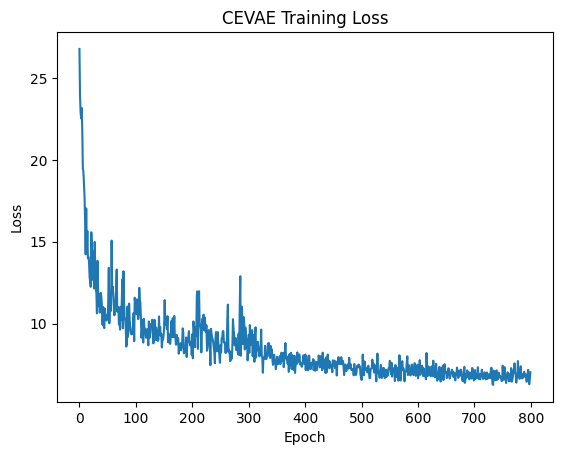

In [10]:
pyro.clear_param_store()

cevae_linear = CEVAE(
    feature_dim=length_x,
    latent_dim=1,
    outcome_dist="normal",
    num_layers=3,
    hidden_dim=200
    )

losses_cevae_linear = cevae_linear.fit(
    x_train_linear, t_train_linear, y_train_linear,
    num_epochs=100,
    batch_size=100,
    learning_rate=5e-3,
    )

plt.plot(losses_cevae_linear)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CEVAE Training Loss')
plt.show()

In [11]:
# Estimate ITEs and ATE
ite_cevae_linear = cevae_linear.ite(x_test_linear)
ate_cevae_linear = ite_cevae_linear.mean().item()

# Compare
print(f"Estimated (test) ATE: {ate_cevae_linear:.4f}")
print(f"True ATE: {ite_test_linear.mean().item():.4f}")

INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.888471


Estimated (test) ATE: 0.8885
True ATE: 1.0000


### <a id='toc2_3_3_'></a>[ITE results Linear Dataset](#toc0_)

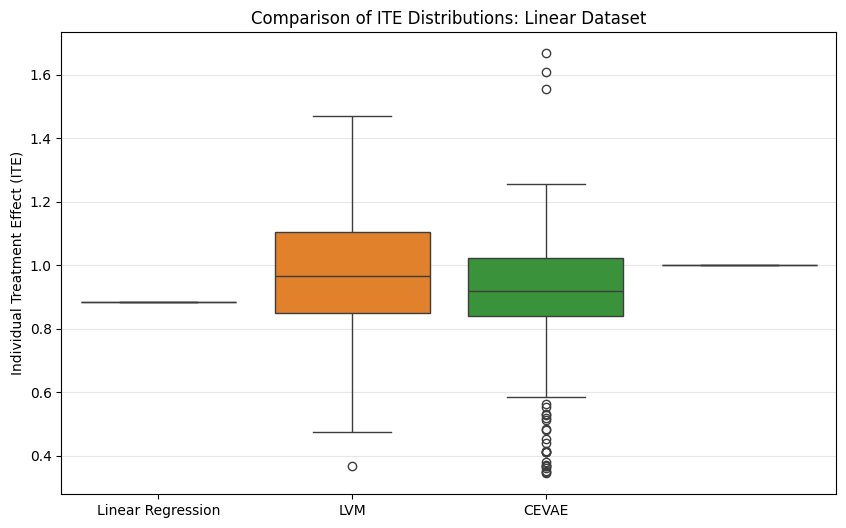

In [12]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=[
        ite_linear_model_ld.flatten().cpu().numpy(),
        ite_pgm_linear.flatten().cpu().detach().numpy(),
        ite_cevae_linear.flatten().cpu().numpy(),
        ite_test_linear.flatten().cpu().numpy()
    ]
)
plt.xticks([0, 1, 2], ["Linear Regression", "LVM", "CEVAE"])
plt.ylabel("Individual Treatment Effect (ITE)")
plt.title("Comparison of ITE Distributions: Linear Dataset")
plt.grid(axis='y', alpha=0.3)
plt.show()

### <a id='toc2_3_4_'></a>[ITE results Non Linear Dataset](#toc0_)

In [13]:
non_linear_data = synthetic_dataset_non_linear(
    n=1000, 
    beta=2.0, 
    num_proxies=10, 
    prior_type='gaussian', 
    seed=0
)

x_non_linear, t_non_linear, y_non_linear, z_non_linear, ite_cevae_non_linear = (
    non_linear_data["x"],
    non_linear_data["t"],
    non_linear_data["y"],
    non_linear_data["z"],
    non_linear_data["ite"]
)

length_x_non_linear = x_non_linear.shape[1]

# ----------------------------- train-test split ----------------------------- #

x_train_non_linear, x_test_non_linear, t_train_non_linear, t_test_non_linear, y_train_non_linear, y_test_non_linear, ite_train_non_linear, ite_test_non_linear = train_test_split(
    x_non_linear, t_non_linear, y_non_linear, ite_cevae_non_linear, test_size=0.2, random_state=0
)

[SVI] epoch  100 ELBO = 37974.42
[SVI] epoch  200 ELBO = 25148.23
[SVI] epoch  300 ELBO = 19459.50
[SVI] epoch  400 ELBO = 17245.87
[SVI] epoch  500 ELBO = 16457.00
[SVI] epoch  600 ELBO = 16097.10
[SVI] epoch  700 ELBO = 15898.29
[SVI] epoch  800 ELBO = 15781.22
[SVI] epoch  900 ELBO = 15656.05
[SVI] epoch 1000 ELBO = 15556.74
[SVI-xt] epoch  101 ELBO = 30452.35
[SVI-xt] epoch  201 ELBO = 23444.93
[SVI-xt] epoch  301 ELBO = 19522.50
[SVI-xt] epoch  401 ELBO = 17060.52
[SVI-xt] epoch  501 ELBO = 15703.56
[SVI-xt] epoch  601 ELBO = 15023.40
[SVI-xt] epoch  701 ELBO = 14711.80
[SVI-xt] epoch  801 ELBO = 14495.28
[SVI-xt] epoch  901 ELBO = 14433.46


INFO 	 Training with 8 minibatches per epoch
DEBUG 	 step     0 loss = 30.06
DEBUG 	 step   100 loss = 10.3039
DEBUG 	 step   200 loss = 9.95053
DEBUG 	 step   300 loss = 10.0923
DEBUG 	 step   400 loss = 10.218
DEBUG 	 step   500 loss = 9.40618
DEBUG 	 step   600 loss = 9.3847
DEBUG 	 step   700 loss = 9.70674


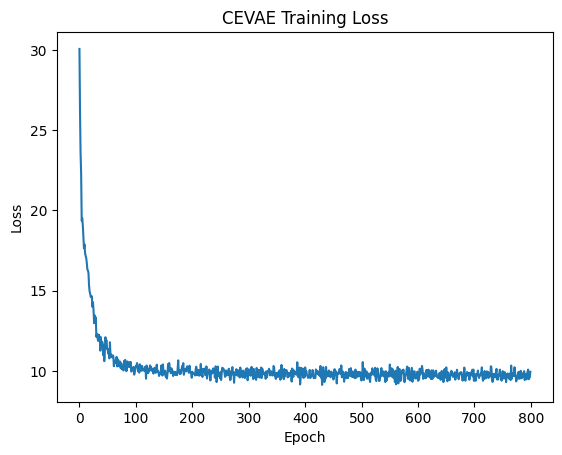

INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.900015


In [14]:
# ----------------------------- LINEAR REGRESSION ---------------------------- #

linear_model_nld = LinearModel()
linear_model_nld.fit(x_train_non_linear, t_train_non_linear, y_train_non_linear)          

ite_linear_model_nld = linear_model_nld.ite(x_test_non_linear)         
ate_linear_model_nld = ite_linear_model_nld.mean().item()

# ----------------- TRAINING THE SIMPLE LATENT VARIABLE MODEL ---------------- #

pgm_nld = PyroLinearProxyModel(init_scale=0.1, learning_rate=5e-3, weight_decay=0.0)
pyro.clear_param_store()

losses_pgm_nld = pgm_nld.fit(x_train_non_linear, t_train_non_linear, y_train_non_linear, num_epochs=1000, log_every=100, posterior_epochs=1000)          

ite_pgm_nld = pgm_nld.ite(x_test_non_linear)         
ate_pgm_nld = ite_pgm_nld.mean().item()
true_ite_nld = ite_test_non_linear

# ---------------------------- TRAINING THE CEVAE ---------------------------- #
pyro.clear_param_store()

cevae_nld = CEVAE(
    feature_dim=length_x_non_linear,
    latent_dim=1,
    outcome_dist="normal",
    num_layers=3,
    hidden_dim=200
    )

losses_cevae_nld = cevae_nld.fit(
    x_train_non_linear, t_train_non_linear, y_train_non_linear,
    num_epochs=100,
    batch_size=100,
    learning_rate=5e-4,
    learning_rate_decay=0.1,
    weight_decay=1e-6
    )

# ---------------------------- PLOT THE CEVAE LOSS --------------------------- #

plt.plot(losses_cevae_nld)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CEVAE Training Loss')
plt.show()

# Estimate ITEs and ATE
ite_cevae_nld = cevae_nld.ite(x_test_non_linear)
ate_cevae_nld = ite_cevae_nld.mean().item()

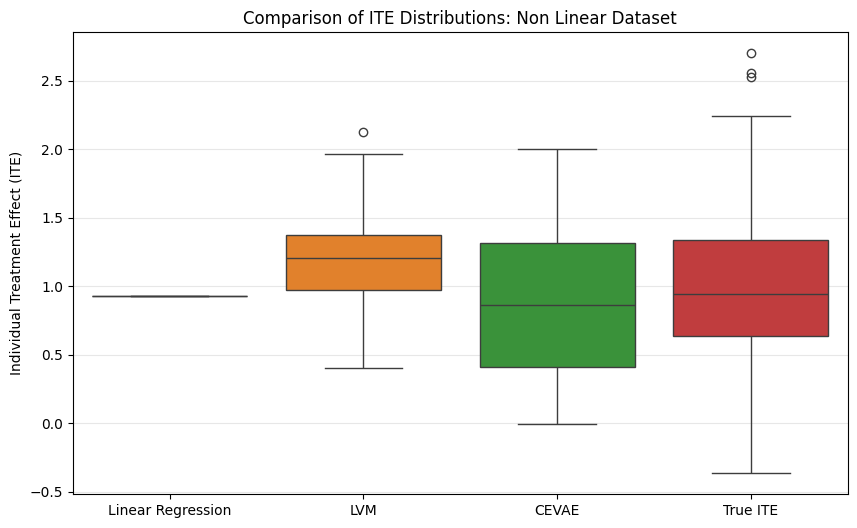

In [15]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=[
        ite_linear_model_nld.flatten().cpu().numpy(),
        ite_pgm_nld.flatten().cpu().detach().numpy(),
        ite_cevae_nld.flatten().cpu().numpy(),
        true_ite_nld.flatten().cpu().numpy()
    ]
)
plt.xticks([0, 1, 2, 3], ["Linear Regression", "LVM", "CEVAE", "True ITE"])
plt.ylabel("Individual Treatment Effect (ITE)")
plt.title("Comparison of ITE Distributions: Non Linear Dataset")
plt.grid(axis='y', alpha=0.3)
plt.show()

#### <a id='toc2_3_4_1_'></a>[Internal Representation](#toc0_)

In [16]:
import torch
import matplotlib.pyplot as plt
from pyro import poutine

@torch.no_grad()
def plot_predicted_vs_true(
    cevae,
    x_test,
    true_g_fn,
    true_tau_fn,
    num_samples: int = 100,
    figsize: tuple = (15,6),
    z_dim: int = 0,
):
    # 1) whiten and sample
    x = cevae.whiten(x_test)
    with pyro.plate("num_particles", num_samples, dim=-2):
        with poutine.trace() as tr, poutine.block(hide=["y", "t"]):
            cevae.guide(x)
        z = tr.trace.nodes["z"]["value"]
        with poutine.do(data={"t": torch.zeros(())}):
            y0_pred = poutine.replay(cevae.model.y_mean, tr.trace)(x)
        with poutine.do(data={"t": torch.ones(())}):
            y1_pred = poutine.replay(cevae.model.y_mean, tr.trace)(x)

    # 2) flatten & sort
    z_flat  = z.reshape(-1, z.shape[-1])
    y0_flat = y0_pred.reshape(-1)
    y1_flat = y1_pred.reshape(-1)
    z_plot  = z_flat[:, z_dim]
    idx     = torch.argsort(z_plot)
    z_s     = z_plot[idx]
    y0_s    = y0_flat[idx]
    y1_s    = y1_flat[idx]

    # 3) true curves
    y0_true = true_g_fn(z_s)
    tau_true = true_tau_fn(z_s)
    y1_true = y0_true + tau_true

    # Compute common y-limits
    all_y = torch.cat([y0_s, y1_s, y0_true, y1_true]).cpu()
    y_min, y_max = all_y.min().item(), all_y.max().item()

    # 4) plot with shared y-axis
    fig, (ax0, ax1) = plt.subplots(
        1, 2,
        figsize=figsize,
        sharey=True  # <–– this makes both subplots use the same y-scale
    )

    # Control
    ax0.scatter(z_s.cpu(), y0_s.cpu(), alpha=0.4, s=10, label="Predicted")
    ax0.plot   (z_s.cpu(), y0_true.cpu(),  '-', linewidth=3, label="True g(z)")
    ax0.set(xlabel=f"Z[{z_dim}]", ylabel="Outcome", title="Control")
    ax0.set_ylim(y_min, y_max)  # enforce identical limits
    ax0.legend(); ax0.grid(True, alpha=0.3)

    # Treatment
    ax1.scatter(z_s.cpu(), y1_s.cpu(), alpha=0.4, s=10, label="Predicted")
    ax1.plot   (z_s.cpu(), y1_true.cpu(),   '-', linewidth=3, label="True g(z)+τ(z)")
    ax1.set(xlabel=f"Z[{z_dim}]", title="Treatment")
    ax1.set_ylim(y_min, y_max)  # same limits as ax0
    ax1.legend(); ax1.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
    return fig, (ax0, ax1)


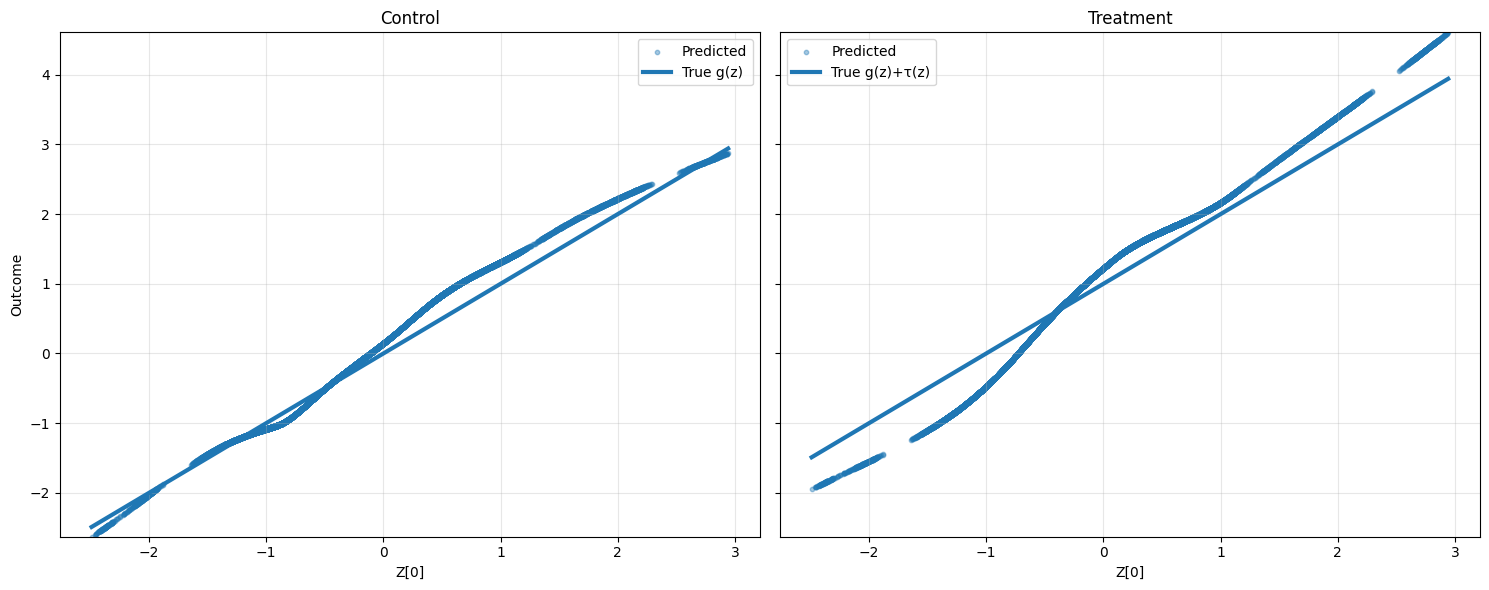

In [17]:
fig, axes = plot_predicted_vs_true(
    cevae_linear,
    x_test_linear,
    true_g_fn=lambda z: 1.0*z,
    true_tau_fn=lambda z: torch.full_like(z, 1.0),
    num_samples=100,
)


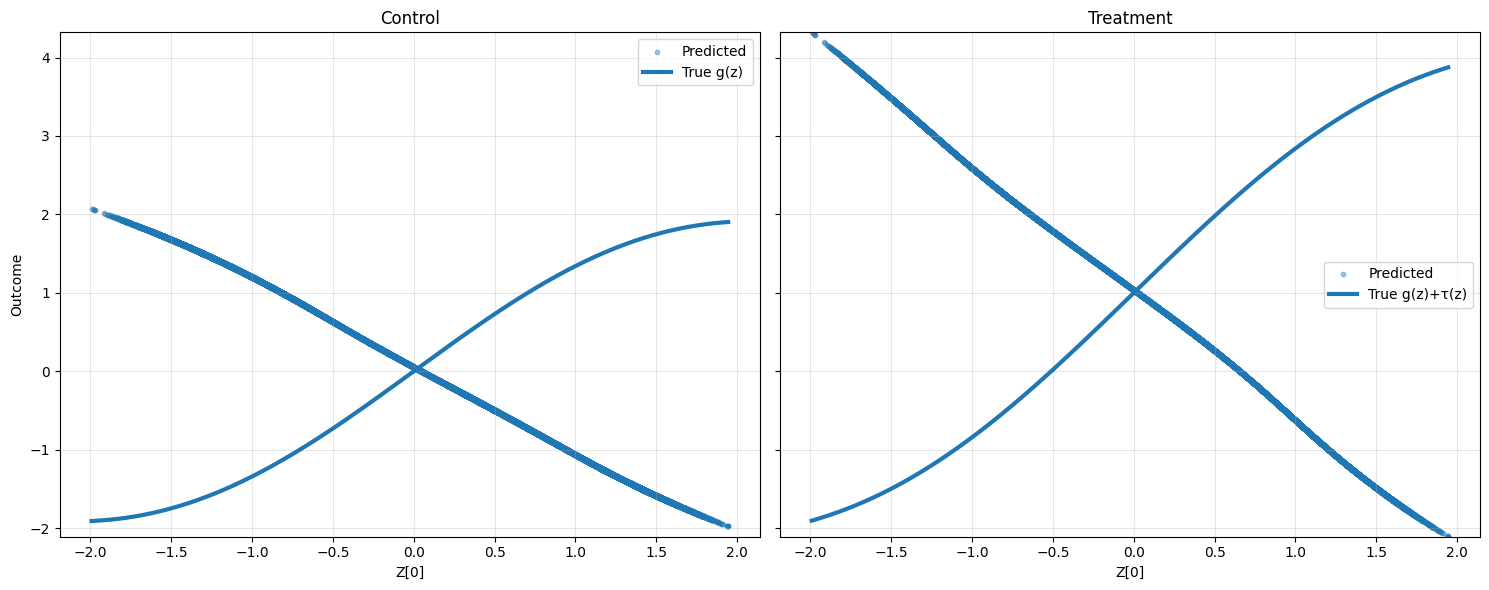

In [18]:
fig, axes = plot_predicted_vs_true(
    cevae_nld,
    x_test_non_linear,
    true_g_fn=lambda z: torch.sin(z) + 0.5*z,
    true_tau_fn=lambda z: 1.0 + 0.5*z,
    num_samples=100,
)


interestingly, for the non linear dataset, we can note that the internal representation in the symmetric one! It can be shown that the two solution are equivalent, i.e., the non linear relationships chosen are invariant under a sign flip.

# <a id='toc3_'></a>[Experiments](#toc0_)

### <a id='toc3_1_1_'></a>[Setting parameters defaults](#toc0_)

In [2]:
num_proxies = 10
n_data = 500

data_defaults_non_lin = dict(
    n=n_data,
    num_proxies=num_proxies,
    sigma_x=1.0,
    sigma_y=1.0,
    prior_type="gaussian",
    seed=0,
)

data_defaults_linear = dict(
    n=n_data,
    beta=1.0,
    num_proxies=num_proxies,
    shuffle_pct=0.0,
    sigma_x=1.0,
    sigma_y=1.0,
    seed=0,
)

model_defaults = dict(
    feature_dim=num_proxies,
    latent_dim=1,
    num_layers=3,   # number of hidden layers
    hidden_dim=200,  # number of hidden units in each layer
    outcome_dist="normal",
)

fit_defaults = dict(
    num_epochs=100,
    batch_size=100,
    learning_rate=5e-3,
    weight_decay=0.0,
    log_every=0,
)

pgm_fit_defaults = dict(
    num_epochs=1000,
    posterior_epochs=1000,
    batch_size=100,  # ignored here, we do full-batch
    learning_rate=5e-3,
    weight_decay=0.0,
    log_every=100,
)

metrics = {
    "abs_ate_err": rel_ate_error,
    "rmse_ite": rmse_ite,
}
datasets = {
    "linear":     (synthetic_dataset_linear,   data_defaults_linear),
    "non_linear": (synthetic_dataset_non_linear, data_defaults_non_lin),
}

models = {
    "pgm":   (PyroLinearProxyModel, {},        pgm_fit_defaults),
    "cevae": (CEVAE,             model_defaults, fit_defaults),
    "lr":    (LinearModel,        {},        {}),
}


### <a id='toc3_1_2_'></a>[E1: increasing sample size](#toc0_)

In [ ]:

param_grid = {
    "data__n": np.linspace(500,2000,10, dtype=int)
}

n_results = compare_all(datasets, models, param_grid, metrics)

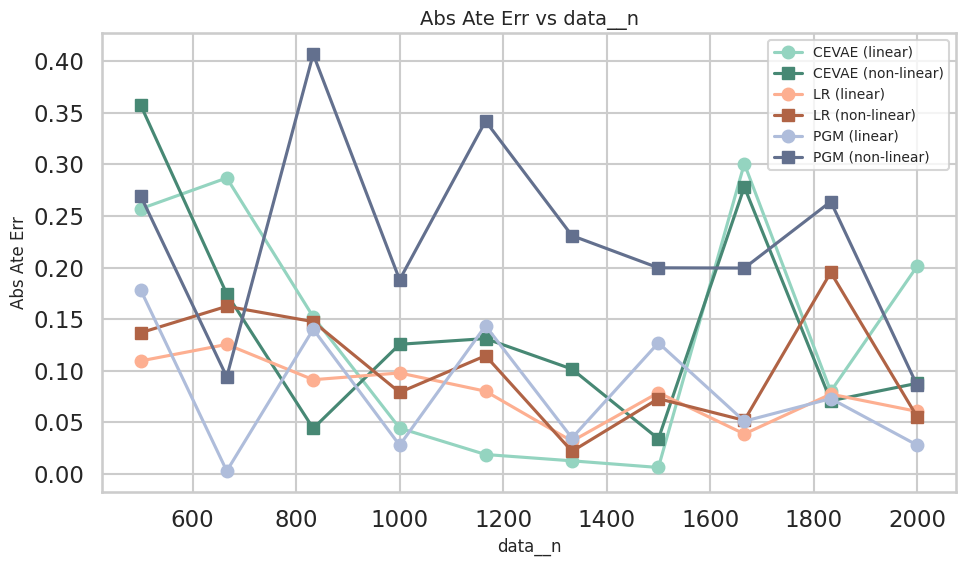

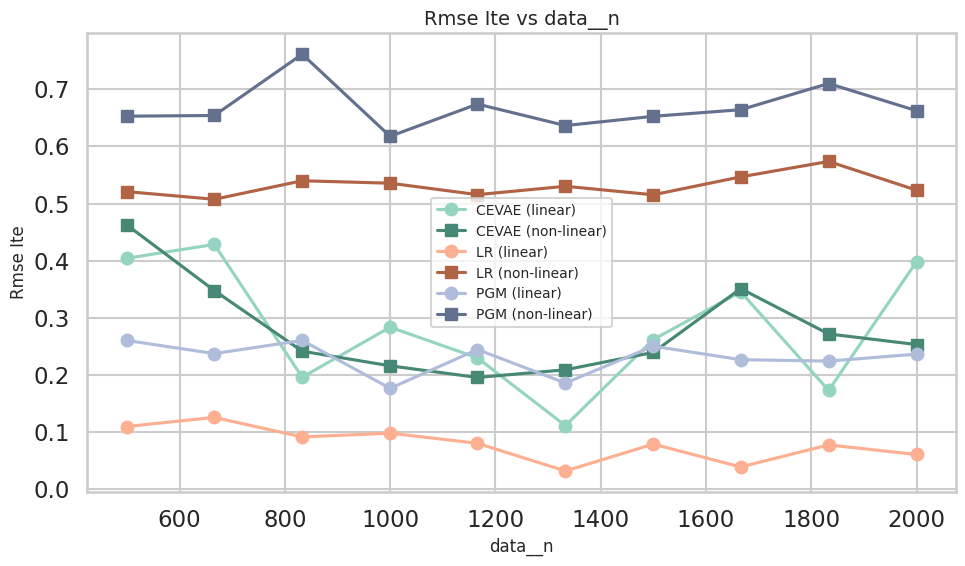

In [28]:
auto_plot_datasets(
  n_results,
  x_param='data__n',
  models=('cevae','lr', 'pgm'),
  ds_names=('linear','non_linear'),
  save_dir="./",
  file_name_template="MyRun_{x_param}--{metric}.pdf",
  show=True 
)

### <a id='toc3_1_3_'></a>[E2: increasing correlation among proxies (not through $Z$)](#toc0_)

In [29]:

param_grid = {
    "data__rho": np.linspace(0.0, 0.9, 10),
}

rho_results = compare_all(datasets, models, param_grid, metrics)

[SVI] epoch  100 ELBO = 26184.39
[SVI] epoch  200 ELBO = 17274.07
[SVI] epoch  300 ELBO = 12860.57
[SVI] epoch  400 ELBO = 10750.25
[SVI] epoch  500 ELBO = 9674.49
[SVI] epoch  600 ELBO = 9137.00
[SVI] epoch  700 ELBO = 8730.33
[SVI] epoch  800 ELBO = 8554.65
[SVI] epoch  900 ELBO = 8410.46
[SVI] epoch 1000 ELBO = 8271.71
[SVI-xt] epoch  101 ELBO = 13699.87
[SVI-xt] epoch  201 ELBO = 10294.40
[SVI-xt] epoch  301 ELBO = 8899.00
[SVI-xt] epoch  401 ELBO = 8247.20
[SVI-xt] epoch  501 ELBO = 7948.70
[SVI-xt] epoch  601 ELBO = 7775.04
[SVI-xt] epoch  701 ELBO = 7686.55
[SVI-xt] epoch  801 ELBO = 7648.41
[SVI-xt] epoch  901 ELBO = 7623.74
[SVI] epoch  100 ELBO = 26240.01
[SVI] epoch  200 ELBO = 17309.52
[SVI] epoch  300 ELBO = 12886.32
[SVI] epoch  400 ELBO = 10771.15
[SVI] epoch  500 ELBO = 9691.70
[SVI] epoch  600 ELBO = 9154.07
[SVI] epoch  700 ELBO = 8748.52
[SVI] epoch  800 ELBO = 8574.47
[SVI] epoch  900 ELBO = 8433.47
[SVI] epoch 1000 ELBO = 8296.85
[SVI-xt] epoch  101 ELBO = 13688.25

INFO 	 Training with 4 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.742853
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.742378
INFO 	 Training with 4 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.686796
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.686071
INFO 	 Training with 4 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.782449
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.782647
INFO 	 Training with 4 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.596868
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.596401
INFO 	 Training with 4 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.802972
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.802778
INFO 	 Training with 4 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.693901
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.69231

[SVI] epoch  100 ELBO = 14077.96
[SVI] epoch  200 ELBO = 10071.19
[SVI] epoch  300 ELBO = 8481.30
[SVI] epoch  400 ELBO = 7939.12
[SVI] epoch  500 ELBO = 7738.92
[SVI] epoch  600 ELBO = 7670.38
[SVI] epoch  700 ELBO = 7606.45
[SVI] epoch  800 ELBO = 7557.78
[SVI] epoch  900 ELBO = 7513.80
[SVI] epoch 1000 ELBO = 7481.70
[SVI-xt] epoch  101 ELBO = 9735.46
[SVI-xt] epoch  201 ELBO = 7519.80
[SVI-xt] epoch  301 ELBO = 7006.23
[SVI-xt] epoch  401 ELBO = 6908.12
[SVI-xt] epoch  501 ELBO = 6884.33
[SVI-xt] epoch  601 ELBO = 6874.68
[SVI-xt] epoch  701 ELBO = 6873.83
[SVI-xt] epoch  801 ELBO = 6874.26
[SVI-xt] epoch  901 ELBO = 6872.87
[SVI] epoch  100 ELBO = 14118.01
[SVI] epoch  200 ELBO = 10100.97
[SVI] epoch  300 ELBO = 8508.59
[SVI] epoch  400 ELBO = 7965.88
[SVI] epoch  500 ELBO = 7766.41
[SVI] epoch  600 ELBO = 7698.19
[SVI] epoch  700 ELBO = 7633.80
[SVI] epoch  800 ELBO = 7584.04
[SVI] epoch  900 ELBO = 7538.99
[SVI] epoch 1000 ELBO = 7505.44
[SVI-xt] epoch  101 ELBO = 9751.33
[SVI-x

INFO 	 Training with 4 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.632827
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.639507
INFO 	 Training with 4 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.550543
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.5555
INFO 	 Training with 4 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.595879
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.597213
INFO 	 Training with 4 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.623952
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.622892
INFO 	 Training with 4 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.641104
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.641133
INFO 	 Training with 4 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.762431
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.762185


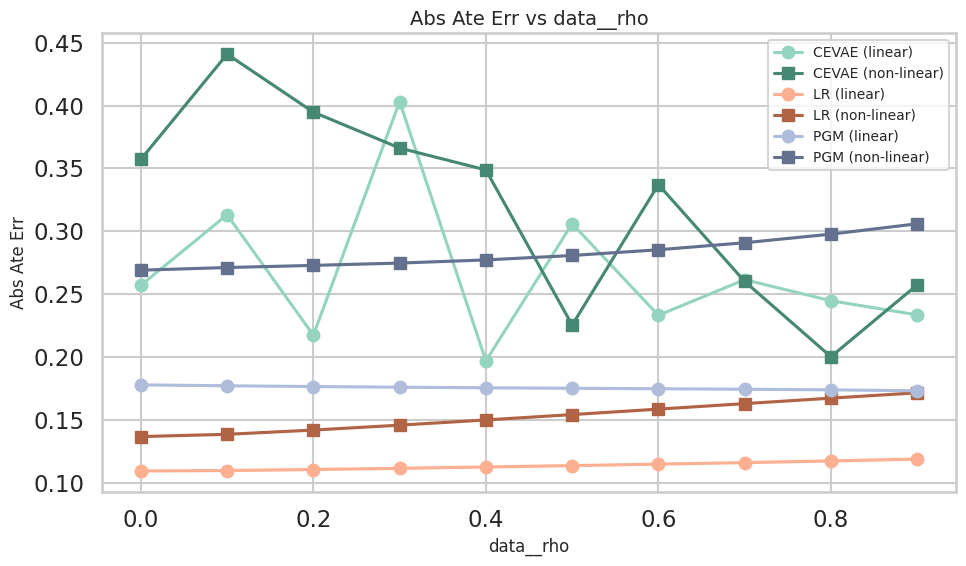

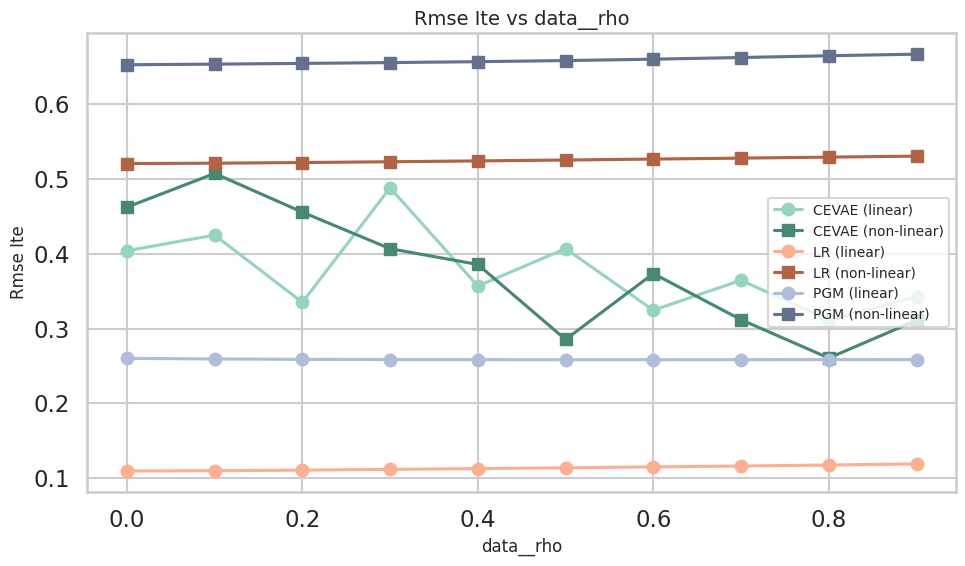

In [30]:
auto_plot_datasets(
  rho_results,
  x_param='data__rho',
  models=('cevae','lr', 'pgm'),
  ds_names=('linear','non_linear'),
  save_dir="./",
  file_name_template="MyRun_{x_param}--{metric}.pdf",
  show=True 
)

### <a id='toc3_1_4_'></a>[E3: increasing decorellation among proxies (through shuffling)](#toc0_)

In [3]:

param_grid = {
    "data__shuffle_pct": np.linspace(0.0, 1.0, 11)
}

shuffle_results = compare_all(datasets, models, param_grid, metrics)

[SVI] epoch  100 ELBO = 26184.39
[SVI] epoch  200 ELBO = 17274.07
[SVI] epoch  300 ELBO = 12860.57
[SVI] epoch  400 ELBO = 10750.25
[SVI] epoch  500 ELBO = 9674.49
[SVI] epoch  600 ELBO = 9137.00
[SVI] epoch  700 ELBO = 8730.33
[SVI] epoch  800 ELBO = 8554.65
[SVI] epoch  900 ELBO = 8410.46
[SVI] epoch 1000 ELBO = 8271.71
[SVI-xt] epoch  101 ELBO = 13699.87
[SVI-xt] epoch  201 ELBO = 10294.40
[SVI-xt] epoch  301 ELBO = 8899.00
[SVI-xt] epoch  401 ELBO = 8247.20
[SVI-xt] epoch  501 ELBO = 7948.70
[SVI-xt] epoch  601 ELBO = 7775.04
[SVI-xt] epoch  701 ELBO = 7686.55
[SVI-xt] epoch  801 ELBO = 7648.41
[SVI-xt] epoch  901 ELBO = 7623.74
[SVI] epoch  100 ELBO = 26318.36
[SVI] epoch  200 ELBO = 17815.32
[SVI] epoch  300 ELBO = 13652.03
[SVI] epoch  400 ELBO = 11639.78
[SVI] epoch  500 ELBO = 10569.84
[SVI] epoch  600 ELBO = 9956.69
[SVI] epoch  700 ELBO = 9588.30
[SVI] epoch  800 ELBO = 9310.17
[SVI] epoch  900 ELBO = 9142.73
[SVI] epoch 1000 ELBO = 8991.04
[SVI-xt] epoch  101 ELBO = 13793.5

INFO 	 Training with 4 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.742853
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.742378
INFO 	 Training with 4 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.871882
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.870119
INFO 	 Training with 4 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.968266
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.9689
INFO 	 Training with 4 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.28801
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.28895
INFO 	 Training with 4 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.764063
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.763355
INFO 	 Training with 4 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.08032
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.07723
INFO

[SVI] epoch  100 ELBO = 14077.96
[SVI] epoch  200 ELBO = 10071.19
[SVI] epoch  300 ELBO = 8481.30
[SVI] epoch  400 ELBO = 7939.12
[SVI] epoch  500 ELBO = 7738.92
[SVI] epoch  600 ELBO = 7670.38
[SVI] epoch  700 ELBO = 7606.45
[SVI] epoch  800 ELBO = 7557.78
[SVI] epoch  900 ELBO = 7513.80
[SVI] epoch 1000 ELBO = 7481.70
[SVI-xt] epoch  101 ELBO = 9735.46
[SVI-xt] epoch  201 ELBO = 7519.80
[SVI-xt] epoch  301 ELBO = 7006.23
[SVI-xt] epoch  401 ELBO = 6908.12
[SVI-xt] epoch  501 ELBO = 6884.33
[SVI-xt] epoch  601 ELBO = 6874.68
[SVI-xt] epoch  701 ELBO = 6873.83
[SVI-xt] epoch  801 ELBO = 6874.26
[SVI-xt] epoch  901 ELBO = 6872.87
[SVI] epoch  100 ELBO = 14246.10
[SVI] epoch  200 ELBO = 10433.54
[SVI] epoch  300 ELBO = 8958.85
[SVI] epoch  400 ELBO = 8437.23
[SVI] epoch  500 ELBO = 8226.63
[SVI] epoch  600 ELBO = 8122.17
[SVI] epoch  700 ELBO = 8061.36
[SVI] epoch  800 ELBO = 8017.07
[SVI] epoch  900 ELBO = 7972.50
[SVI] epoch 1000 ELBO = 7939.82
[SVI-xt] epoch  101 ELBO = 9662.82
[SVI-x

INFO 	 Training with 4 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.632827
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.639507
INFO 	 Training with 4 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.961141
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.955382
INFO 	 Training with 4 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.985858
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.992759
INFO 	 Training with 4 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.37847
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.37341
INFO 	 Training with 4 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.994799
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.0004
INFO 	 Training with 4 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.12312
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.11933
INFO

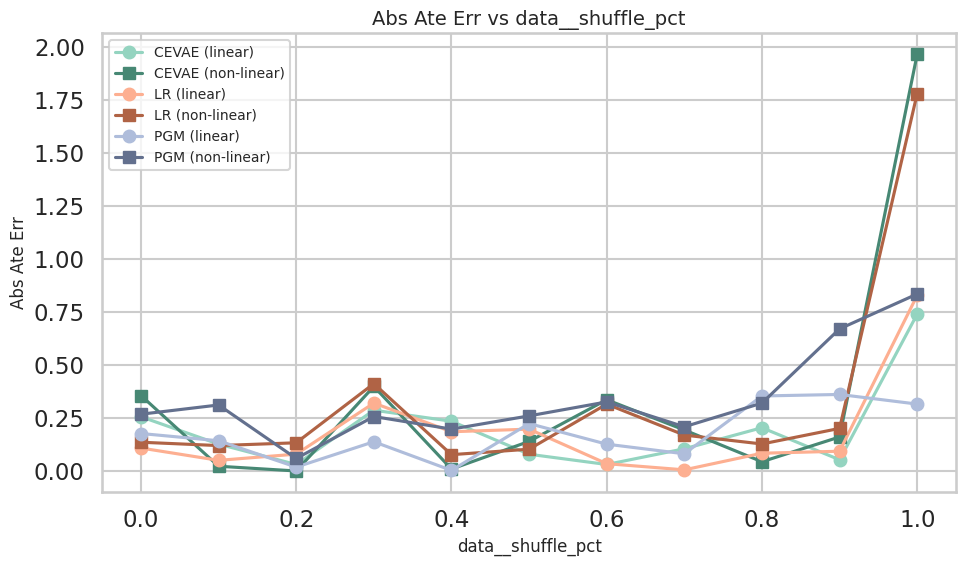

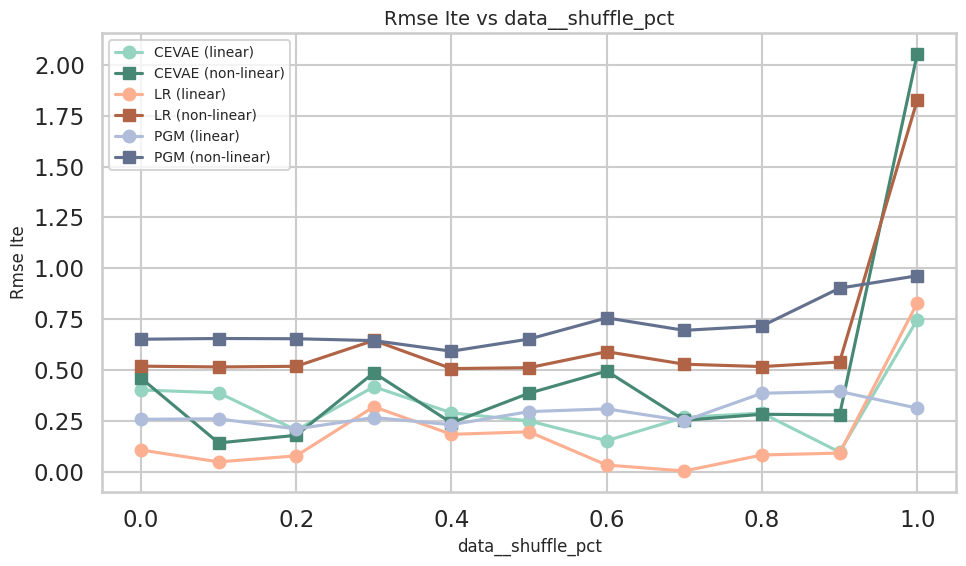

In [4]:
auto_plot_datasets(
  shuffle_results,
  x_param='data__shuffle_pct',
  models=('cevae','lr', 'pgm'),
  ds_names=('linear','non_linear'),
  save_dir="./",
  file_name_template="MyRun_{x_param}--{metric}.pdf",
  show=True 
)

### <a id='toc3_1_5_'></a>[E4: increasing the latent dimension (of the CEVAE)](#toc0_)

In [ ]:
models = {
    "pgm":   (PyroLinearProxyModel, {},        pgm_fit_defaults),
    "cevae": (CEVAE,             model_defaults, fit_defaults),
}

In [16]:

param_grid = {
    "model__latent_dim": [2, 5, 10, 20],
}

latent_dim_results = compare_all(datasets, models, param_grid, metrics)

[SVI] epoch  100 ELBO = 24689.07
[SVI] epoch  200 ELBO = 14681.05
[SVI] epoch  300 ELBO = 10905.76
[SVI] epoch  400 ELBO = 9679.63
[SVI] epoch  500 ELBO = 9079.36
[SVI] epoch  600 ELBO = 8727.99
[SVI] epoch  700 ELBO = 8531.85
[SVI] epoch  800 ELBO = 8411.48
[SVI] epoch  900 ELBO = 8290.53
[SVI] epoch 1000 ELBO = 8158.31
[SVI-xt] epoch  101 ELBO = 13712.07
[SVI-xt] epoch  201 ELBO = 9709.45
[SVI-xt] epoch  301 ELBO = 8393.42
[SVI-xt] epoch  401 ELBO = 7936.63
[SVI-xt] epoch  501 ELBO = 7744.60
[SVI-xt] epoch  601 ELBO = 7623.29
[SVI-xt] epoch  701 ELBO = 7569.60
[SVI-xt] epoch  801 ELBO = 7560.74
[SVI-xt] epoch  901 ELBO = 7550.90
[SVI] epoch  100 ELBO = 22076.25
[SVI] epoch  200 ELBO = 12161.26
[SVI] epoch  300 ELBO = 10108.14
[SVI] epoch  400 ELBO = 9540.98
[SVI] epoch  500 ELBO = 9181.32
[SVI] epoch  600 ELBO = 9041.34
[SVI] epoch  700 ELBO = 8895.74
[SVI] epoch  800 ELBO = 8742.72
[SVI] epoch  900 ELBO = 8574.42
[SVI] epoch 1000 ELBO = 8550.50
[SVI-xt] epoch  101 ELBO = 13244.04
[S

INFO 	 Training with 4 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.675752
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.662493
INFO 	 Training with 4 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.84594
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.83196
INFO 	 Training with 4 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.805222
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.779522
INFO 	 Training with 4 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.765374
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.765318


[SVI] epoch  100 ELBO = 13351.54
[SVI] epoch  200 ELBO = 9089.03
[SVI] epoch  300 ELBO = 8143.01
[SVI] epoch  400 ELBO = 7940.98
[SVI] epoch  500 ELBO = 7852.96
[SVI] epoch  600 ELBO = 7748.63
[SVI] epoch  700 ELBO = 7643.59
[SVI] epoch  800 ELBO = 7594.50
[SVI] epoch  900 ELBO = 7534.81
[SVI] epoch 1000 ELBO = 7482.58
[SVI-xt] epoch  101 ELBO = 10041.08
[SVI-xt] epoch  201 ELBO = 7536.11
[SVI-xt] epoch  301 ELBO = 7010.76
[SVI-xt] epoch  401 ELBO = 6908.38
[SVI-xt] epoch  501 ELBO = 6894.53
[SVI-xt] epoch  601 ELBO = 6880.47
[SVI-xt] epoch  701 ELBO = 6875.02
[SVI-xt] epoch  801 ELBO = 6878.14
[SVI-xt] epoch  901 ELBO = 6878.14
[SVI] epoch  100 ELBO = 12606.28
[SVI] epoch  200 ELBO = 9308.17
[SVI] epoch  300 ELBO = 8677.17
[SVI] epoch  400 ELBO = 8451.38
[SVI] epoch  500 ELBO = 8268.74
[SVI] epoch  600 ELBO = 8183.33
[SVI] epoch  700 ELBO = 8127.18
[SVI] epoch  800 ELBO = 8037.01
[SVI] epoch  900 ELBO = 7933.32
[SVI] epoch 1000 ELBO = 7973.07
[SVI-xt] epoch  101 ELBO = 10281.85
[SVI-x

INFO 	 Training with 4 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.448697
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.454603
INFO 	 Training with 4 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.681714
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.68467
INFO 	 Training with 4 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.655898
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.644613
INFO 	 Training with 4 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.732971
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.736479


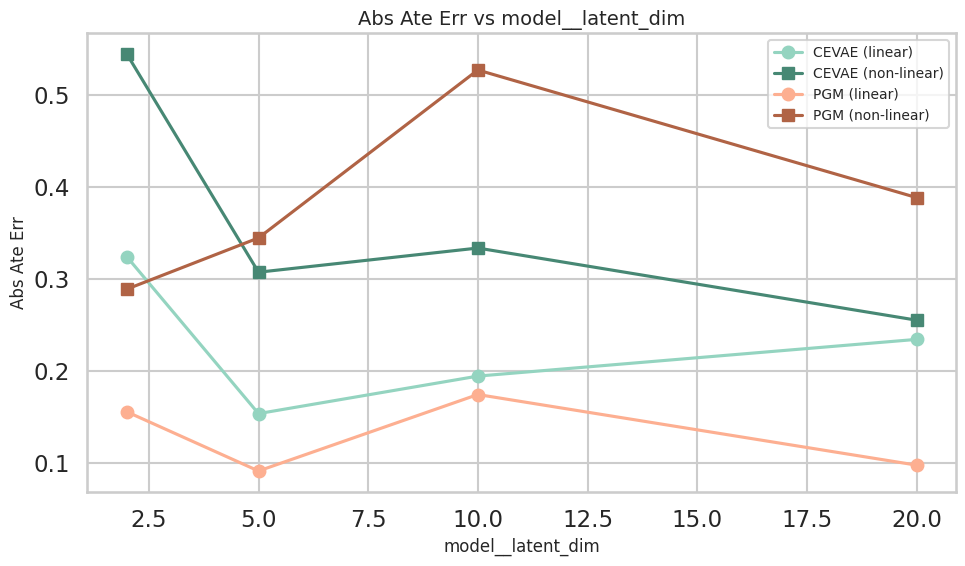

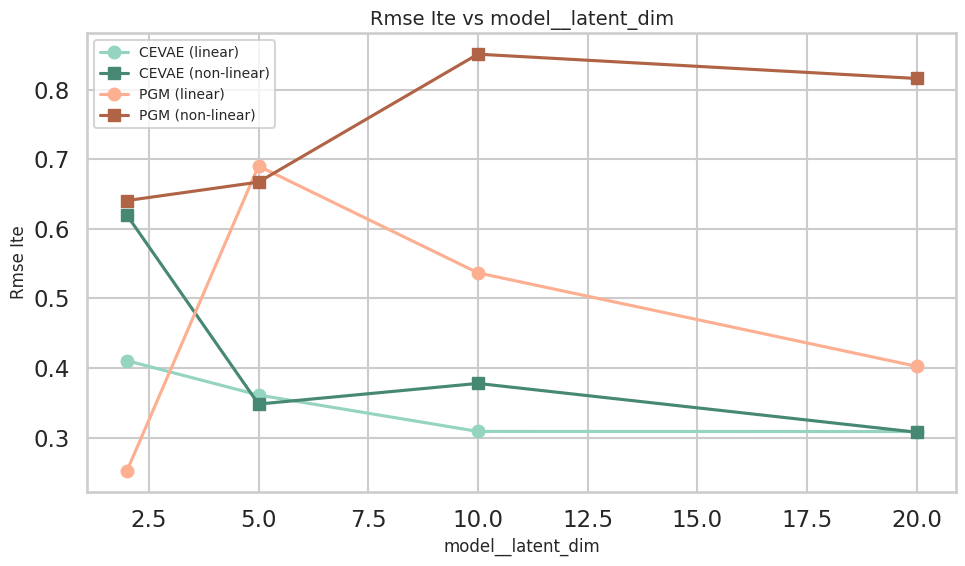

In [ ]:
auto_plot_datasets(
  latent_dim_results,
  x_param='model__latent_dim',
  models=('cevae', 'pgm'),
  ds_names=('linear','non_linear'),
  save_dir="./",
  file_name_template="MyRun_{x_param}--{metric}.pdf",
  show=True 
)

### <a id='toc3_1_6_'></a>[E5: prior misspecification](#toc0_)

In [ ]:
models = {
    "pgm":   (PyroLinearProxyModel, {},        pgm_fit_defaults),
    "cevae": (CEVAE,             model_defaults, fit_defaults),
    "lr":    (LinearModel,        {},        {}),
}

In [23]:

param_grid = {
    "data__prior_type": ["gaussian", "bimodal", "lognormal"],  # type of prior distribution
}

prior_type_results = compare_all(datasets, models, param_grid, metrics)

[SVI] epoch  100 ELBO = 26184.40
[SVI] epoch  200 ELBO = 17274.07
[SVI] epoch  300 ELBO = 12860.57
[SVI] epoch  400 ELBO = 10750.25
[SVI] epoch  500 ELBO = 9674.49
[SVI] epoch  600 ELBO = 9137.00
[SVI] epoch  700 ELBO = 8730.33
[SVI] epoch  800 ELBO = 8554.65
[SVI] epoch  900 ELBO = 8410.46
[SVI] epoch 1000 ELBO = 8271.71
[SVI-xt] epoch  101 ELBO = 13699.87
[SVI-xt] epoch  201 ELBO = 10294.40
[SVI-xt] epoch  301 ELBO = 8899.00
[SVI-xt] epoch  401 ELBO = 8247.20
[SVI-xt] epoch  501 ELBO = 7948.70
[SVI-xt] epoch  601 ELBO = 7775.04
[SVI-xt] epoch  701 ELBO = 7686.55
[SVI-xt] epoch  801 ELBO = 7648.41
[SVI-xt] epoch  901 ELBO = 7623.74
[SVI] epoch  100 ELBO = 504565.03
[SVI] epoch  200 ELBO = 321765.10
[SVI] epoch  300 ELBO = 221202.02
[SVI] epoch  400 ELBO = 156608.99
[SVI] epoch  500 ELBO = 111726.40
[SVI] epoch  600 ELBO = 80969.37
[SVI] epoch  700 ELBO = 59181.41
[SVI] epoch  800 ELBO = 44142.63
[SVI] epoch  900 ELBO = 33830.23
[SVI] epoch 1000 ELBO = 26967.69
[SVI-xt] epoch  101 ELBO

INFO 	 Training with 4 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.742853
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.742378
INFO 	 Training with 4 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.360131
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.351717
INFO 	 Training with 4 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.717231
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.717264


[SVI] epoch  100 ELBO = 14077.96
[SVI] epoch  200 ELBO = 10071.19
[SVI] epoch  300 ELBO = 8481.30
[SVI] epoch  400 ELBO = 7939.12
[SVI] epoch  500 ELBO = 7738.92
[SVI] epoch  600 ELBO = 7670.38
[SVI] epoch  700 ELBO = 7606.45
[SVI] epoch  800 ELBO = 7557.78
[SVI] epoch  900 ELBO = 7513.80
[SVI] epoch 1000 ELBO = 7481.70
[SVI-xt] epoch  101 ELBO = 9735.46
[SVI-xt] epoch  201 ELBO = 7519.80
[SVI-xt] epoch  301 ELBO = 7006.23
[SVI-xt] epoch  401 ELBO = 6908.12
[SVI-xt] epoch  501 ELBO = 6884.33
[SVI-xt] epoch  601 ELBO = 6874.68
[SVI-xt] epoch  701 ELBO = 6873.83
[SVI-xt] epoch  801 ELBO = 6874.26
[SVI-xt] epoch  901 ELBO = 6872.87
[SVI] epoch  100 ELBO = 32029.23
[SVI] epoch  200 ELBO = 17902.64
[SVI] epoch  300 ELBO = 11726.41
[SVI] epoch  400 ELBO = 9493.43
[SVI] epoch  500 ELBO = 8714.75
[SVI] epoch  600 ELBO = 8438.91
[SVI] epoch  700 ELBO = 8296.85
[SVI] epoch  800 ELBO = 8220.73
[SVI] epoch  900 ELBO = 8159.14
[SVI] epoch 1000 ELBO = 8093.42
[SVI-xt] epoch  101 ELBO = 13116.15
[SVI

INFO 	 Training with 4 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.632827
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.639507
INFO 	 Training with 4 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = -0.677161
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = -0.686402
INFO 	 Training with 4 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.83612
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.93544


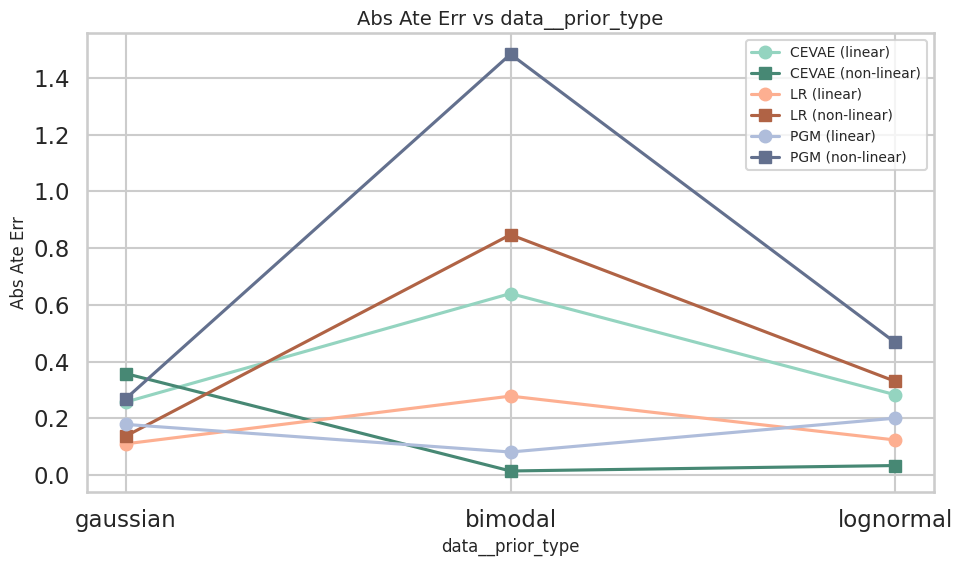

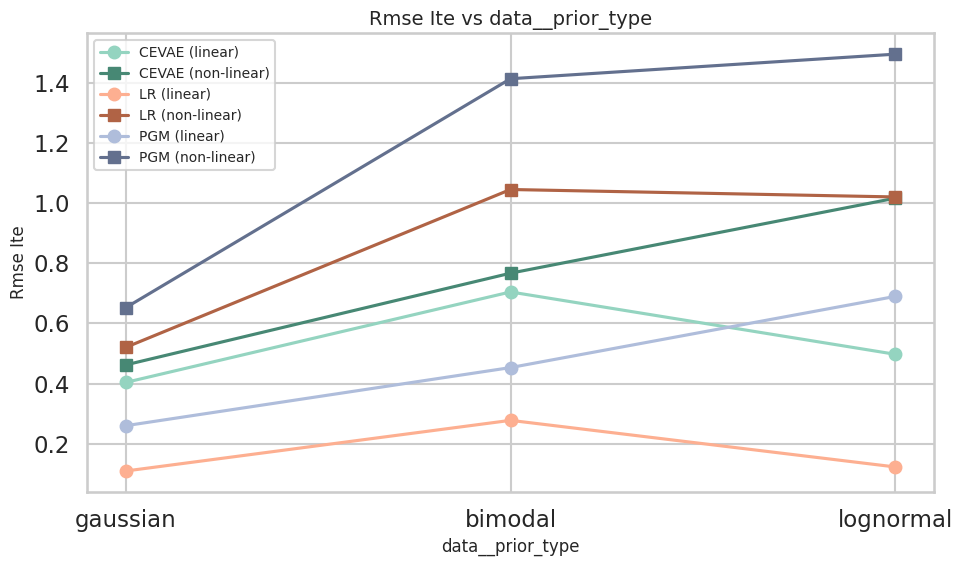

In [24]:
auto_plot_datasets(
  prior_type_results,
  x_param='data__prior_type',
  models=('cevae','lr', 'pgm'),
  ds_names=('linear','non_linear'),
  save_dir="./",
  file_name_template="MyRun_{x_param}--{metric}.pdf",
  show=True 
)

### <a id='toc3_1_7_'></a>[E8: increasing the number of proxies](#toc0_)

In [25]:
# set up params to sweep
param_grid = {
    "data__num_proxies": np.linspace(10,50,10, dtype=int),  # number of proxy variables
}

num_proxies_results = compare_all(datasets, models, param_grid, metrics)

[SVI] epoch  100 ELBO = 26184.40
[SVI] epoch  200 ELBO = 17274.07
[SVI] epoch  300 ELBO = 12860.57
[SVI] epoch  400 ELBO = 10750.25
[SVI] epoch  500 ELBO = 9674.49
[SVI] epoch  600 ELBO = 9137.00
[SVI] epoch  700 ELBO = 8730.33
[SVI] epoch  800 ELBO = 8554.65
[SVI] epoch  900 ELBO = 8410.46
[SVI] epoch 1000 ELBO = 8271.71
[SVI-xt] epoch  101 ELBO = 13699.87
[SVI-xt] epoch  201 ELBO = 10294.40
[SVI-xt] epoch  301 ELBO = 8899.00
[SVI-xt] epoch  401 ELBO = 8247.20
[SVI-xt] epoch  501 ELBO = 7948.70
[SVI-xt] epoch  601 ELBO = 7775.04
[SVI-xt] epoch  701 ELBO = 7686.55
[SVI-xt] epoch  801 ELBO = 7648.41
[SVI-xt] epoch  901 ELBO = 7623.74
[SVI] epoch  100 ELBO = 39263.54
[SVI] epoch  200 ELBO = 25618.48
[SVI] epoch  300 ELBO = 18663.20
[SVI] epoch  400 ELBO = 15198.28
[SVI] epoch  500 ELBO = 13370.39
[SVI] epoch  600 ELBO = 12416.71
[SVI] epoch  700 ELBO = 11802.77
[SVI] epoch  800 ELBO = 11403.08
[SVI] epoch  900 ELBO = 11147.55
[SVI] epoch 1000 ELBO = 10951.76
[SVI-xt] epoch  101 ELBO = 19

INFO 	 Training with 4 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.742853
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.742378
INFO 	 Training with 4 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.849511
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.849405
INFO 	 Training with 4 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.05846
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.05812
INFO 	 Training with 4 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.07741
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.07767
INFO 	 Training with 4 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.25212
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.25244
INFO 	 Training with 4 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.95668
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.955405
INFO 

[SVI] epoch  100 ELBO = 14077.96
[SVI] epoch  200 ELBO = 10071.19
[SVI] epoch  300 ELBO = 8481.30
[SVI] epoch  400 ELBO = 7939.12
[SVI] epoch  500 ELBO = 7738.92
[SVI] epoch  600 ELBO = 7670.38
[SVI] epoch  700 ELBO = 7606.45
[SVI] epoch  800 ELBO = 7557.78
[SVI] epoch  900 ELBO = 7513.80
[SVI] epoch 1000 ELBO = 7481.70
[SVI-xt] epoch  101 ELBO = 9735.46
[SVI-xt] epoch  201 ELBO = 7519.80
[SVI-xt] epoch  301 ELBO = 7006.23
[SVI-xt] epoch  401 ELBO = 6908.12
[SVI-xt] epoch  501 ELBO = 6884.33
[SVI-xt] epoch  601 ELBO = 6874.68
[SVI-xt] epoch  701 ELBO = 6873.83
[SVI-xt] epoch  801 ELBO = 6874.26
[SVI-xt] epoch  901 ELBO = 6872.87
[SVI] epoch  100 ELBO = 20229.65
[SVI] epoch  200 ELBO = 14214.95
[SVI] epoch  300 ELBO = 11679.22
[SVI] epoch  400 ELBO = 10710.80
[SVI] epoch  500 ELBO = 10343.95
[SVI] epoch  600 ELBO = 10177.35
[SVI] epoch  700 ELBO = 10082.55
[SVI] epoch  800 ELBO = 10010.84
[SVI] epoch  900 ELBO = 9949.38
[SVI] epoch 1000 ELBO = 9908.47
[SVI-xt] epoch  101 ELBO = 13984.09

INFO 	 Training with 4 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.632827
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.639507
INFO 	 Training with 4 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.930195
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.931301
INFO 	 Training with 4 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.12936
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.13032
INFO 	 Training with 4 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.07762
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.07346
INFO 	 Training with 4 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.44386
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.44474
INFO 	 Training with 4 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.936337
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.942223
INFO

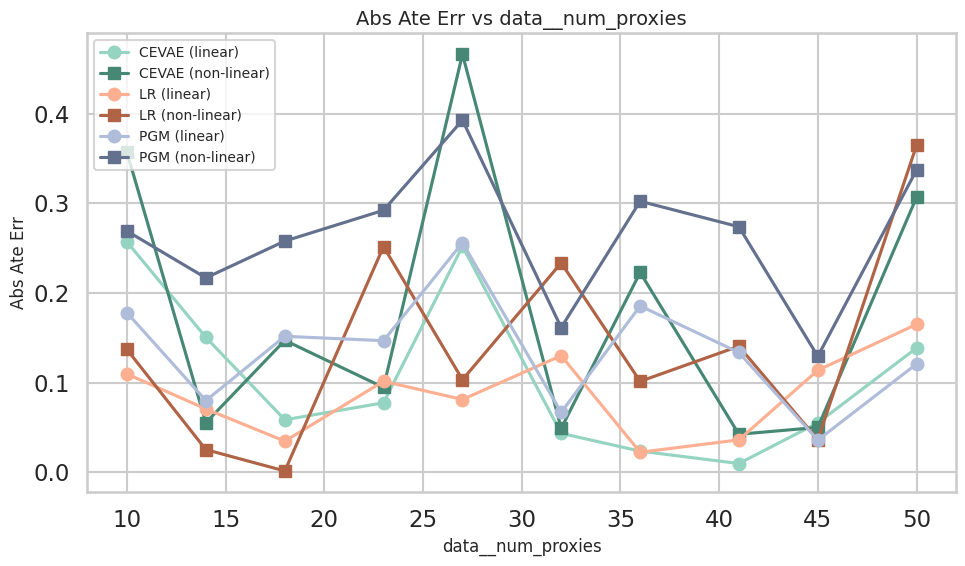

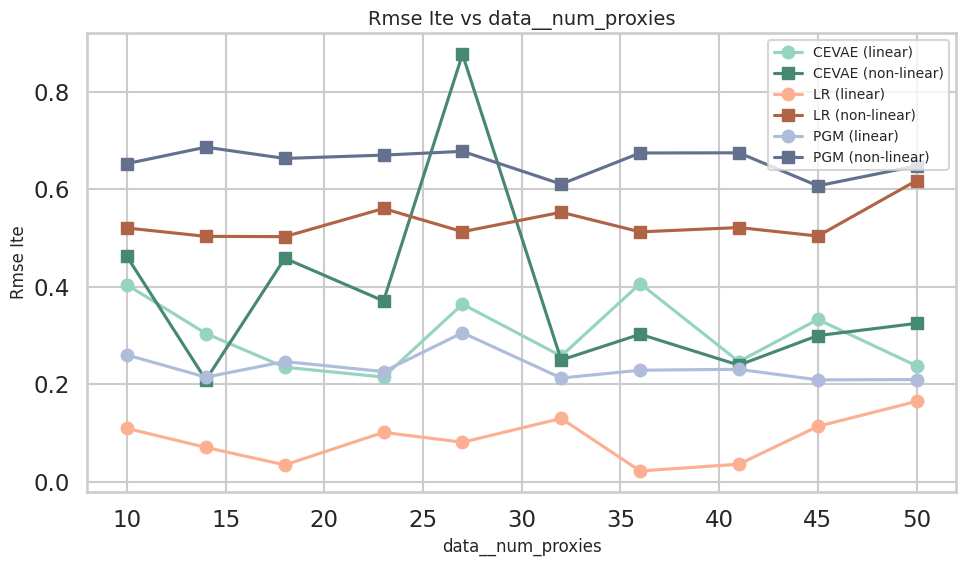

In [26]:
auto_plot_datasets(
  num_proxies_results,
  x_param='data__num_proxies',
  models=('cevae','lr', 'pgm'),
  ds_names=('linear','non_linear'),
  save_dir="./",
  file_name_template="MyRun_{x_param}--{metric}.pdf",
  show=True 
)